In [1]:
from collections import Counter
from inspect import signature
from IPython.display import display
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn import tree
from sklearn import linear_model
from sklearn.metrics import precision_recall_curve
from sklearn.model_selection import StratifiedKFold

from data_loading import load_mibig_metadata, load_data
from prediction_utils import siderophore_preprocess, fit_classifier

# Overview

In this notebook we will perform the cross-validation and bootstrap analyses for just siderophore prediction with pfam transporters. The functions we explain here will then be used more tersely in a followup notebook. The main analyses will be

1. Examine stability of the PR curve and auPR under perturbations for both lasso and decision tree.
2. Examine stability of rules learned by the tree under perturbations.
3. Examine stability of lasso variables under perturbations.

As always, start by loading data.

In [2]:
meta = load_mibig_metadata()
datasets = load_data(meta)

full_pfam = datasets['pfam']

pfam = siderophore_preprocess(full_pfam, meta)

Using 848 BGCs with both pfam and cath transporters, as well as Gram +/-.
Dataset pfam has 0 examples with all zeros.
Dataset cath has 0 examples with all zeros.
Dataset sbp has 759 examples with all zeros.
Dataset biosynthetic has 115 examples with all zeros.


Let's remind ourselves how to fit a classifier on the full data.

In [3]:
def create_clf_data(df):
    X = df.drop(['BGC', 'label', 'Gram'], axis=1)
    y = df['label'].to_numpy()
    return X, y

In [4]:
clf = tree.DecisionTreeClassifier(max_depth=2, min_samples_split=3)

d = pfam.groupby('Gram').get_group(0)
X, y = create_clf_data(d)

fit_clf, precision, recall, aupr = fit_classifier(X, y, clf)

Here's a simple function to plot the PR curve for this classifier.

In [5]:
def plot_pr_curve(precision, recall, color='black'):
    step_kwargs = ({'step': 'post'}
                  if 'step' in signature(plt.fill_between).parameters
                   else {})
    plt.step(recall, precision, alpha=1., color=color,
             where='post')

    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.ylim([0.0, 1.05])
    plt.xlim([0.0, 1.0])

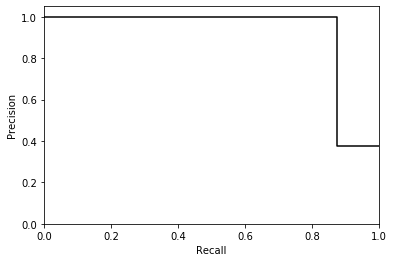

In [6]:
plot_pr_curve(precision, recall)

# Stability of PR Curve

`num_splits`: Number of folds

`num_repeats`: Number of full cross-validations to do

`tree_depth`: Depth of decision tree.

We do stratified K-fold cross validation. Stratifying ensures there are the same number of positive examples per fold (plus or minus 1). We also repeat this some number of times.

We do not plot a pr curve for every fold. Instead, we fit the model on the larger chunk and test it on the held out chunk. Because we are doing cross-validation, every example is in a single test set. This means we get one prediction for every example and make a single PR curve per cross validation. 

We plot the PR curve for each repeat separately. They're all perfect..

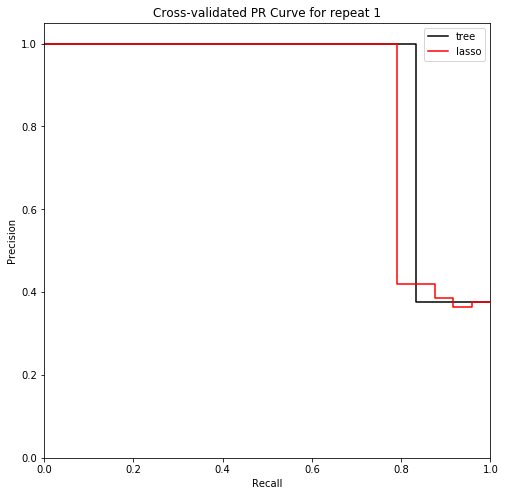

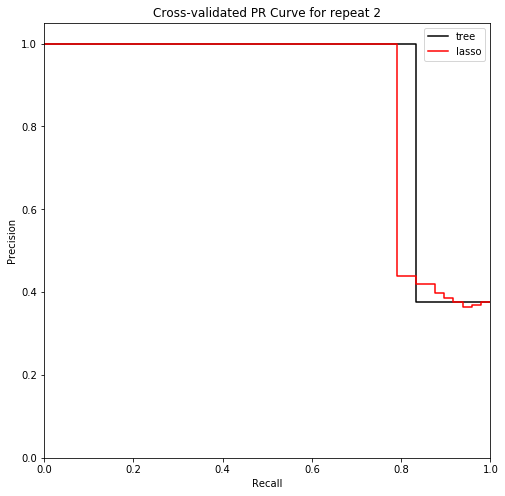

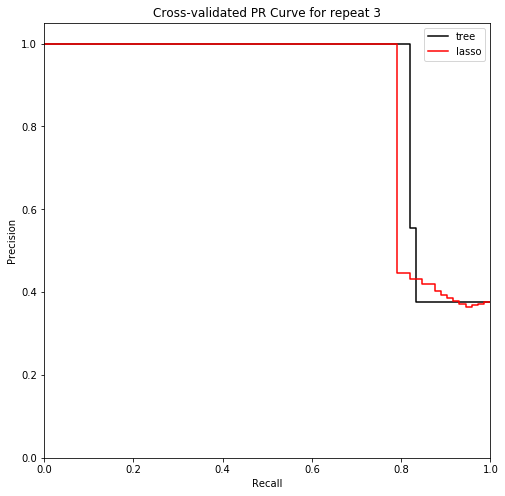

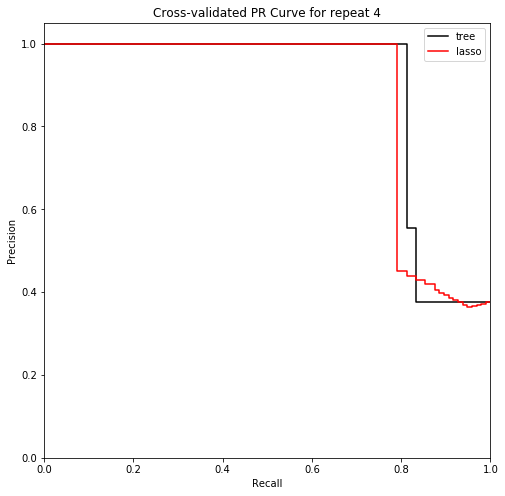

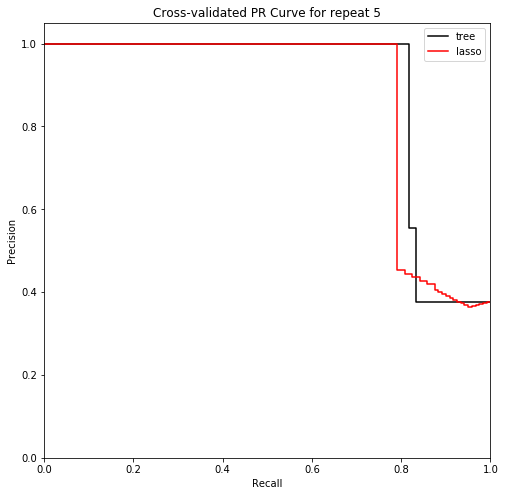

In [7]:
num_splits = 5
num_repeats = 5
tree_depth = 2

kf = StratifiedKFold(n_splits=num_splits)
tree_predictions = [] 
lasso_predictions = []
labels = []

X, y = create_clf_data(d)
for i in range(num_repeats):
    plt.figure(figsize=(8, 8))
    for train, test in kf.split(X, y):
        clf = tree.DecisionTreeClassifier(max_depth=tree_depth, min_samples_split=3)
        X_train, y_train = create_clf_data(d.iloc[train])
        X_test, y_test = create_clf_data(d.iloc[test])

        fit_clf, _, _, _ = fit_classifier(X_train, y_train, clf)

        preds = fit_clf.predict_proba(X_test)
        labels.extend(y_test)
        tree_predictions.extend(preds[:, 1])   
        
        clf = linear_model.LogisticRegression(penalty='l1', solver='liblinear')
        
        fit_clf, _, _, _ = fit_classifier(X_train, y_train, clf)

        preds = fit_clf.predict_proba(X_test)
        lasso_predictions.extend(preds[:, 1])
    
    precision, recall, _ = precision_recall_curve(labels, tree_predictions)
    plot_pr_curve(precision, recall)
    precision, recall, _ = precision_recall_curve(labels, lasso_predictions)
    plot_pr_curve(precision, recall, color='red')
    plt.legend(['tree', 'lasso'])
    plt.title(f'Cross-validated PR Curve for repeat {i+1}')
    plt.show()  

# Tree Visualization

We can now also plot the tree for each fold of cross-validation. We see that the first branch is completely stable, but the second falls into two classes. We can also increase `n_repeats` to see if this is true for many cross validations.

In [8]:
def create_rule(feature, threshold):
    return f'{feature_names[feature]} <= {threshold}'

In [9]:
num_splits = 5
num_repeats = 5
tree_depth = 2

kf = StratifiedKFold(n_splits=num_splits)
rules = []
nums = []

X, y = create_clf_data(d)
feature_names = d.columns.drop(['BGC', 'label', 'Gram'])
for i in range(num_repeats):
#     plt.figure(figsize=(12,12))
    for j, (train, test) in enumerate(kf.split(X, y)):
        clf = tree.DecisionTreeClassifier(max_depth=tree_depth, min_samples_split=3)
        X_train, y_train = create_clf_data(d.iloc[train])
        X_test, y_test = create_clf_data(d.iloc[test])

        fit_clf, _, _, _ = fit_classifier(X_train, y_train, clf)
        
#         # uncomment this to plot all trees
#         tree.plot_tree(fit_clf, feature_names=feature_names) 
#         plt.title(f'Repeat {i}, Fold {j}')
#         plt.show()

        features = fit_clf.tree_.feature[:tree_depth]
        thresholds = fit_clf.tree_.threshold[:tree_depth]
        
        cur_rules = [create_rule(f, t) for (f, t) in zip(features, thresholds)]
        num_split = fit_clf.tree_.weighted_n_node_samples[::-1][:tree_depth]
        rules.append(cur_rules) 
        nums.append(num_split)

Plotting a ton of trees is hard to interpret. Instead we will plot the number of times each unique rule appears. This plot has a few components:

- x axis: Number of times a rule appears (count)
- left y axis: Name of rule
- right y axis: Number of examples this rule actually split on average

Notice that the level 2 rules are not splitting much!

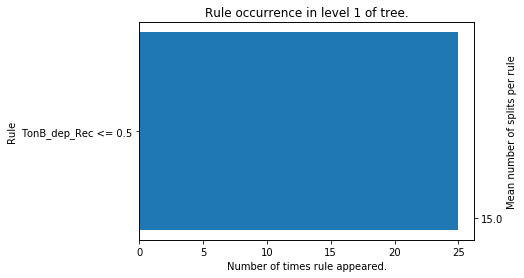

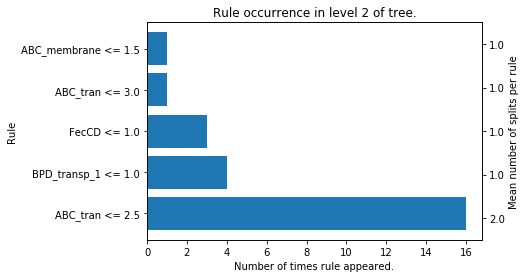

In [10]:
flatten = lambda l: [item for sublist in l for item in sublist]

reordered_rules = [[r[i] for r in rules] for i in range(tree_depth)]
reordered_nums = [[r[i] for r in nums] for i in range(tree_depth)]

mapped_nums = {r: n for r, n in list(zip(flatten(reordered_rules), flatten(reordered_nums)))}

mean_nums = {r: np.mean(n) for r, n in mapped_nums.items()}

for level in range(tree_depth):
    c = Counter(reordered_rules[level])
    labels, counts = zip(*c.items())
    
    idx = np.arange(len(labels))
    fig, ax = plt.subplots()
    ax_count = ax.twinx()
    ax.barh(idx, counts, 0.8)
    ax.set_title(f'Rule occurrence in level {level+1} of tree.')
    ax.set_yticks(idx)
    ax.set_yticklabels(labels)
    ax.set_ylabel('Rule')
    ax.set_xlabel('Number of times rule appeared.')
    ax_count.set_yticks(idx*(1/len(labels)) + 0.1)
    ax_count.set_yticklabels([mean_nums[l] for l in labels])
    ax_count.set_ylabel('Mean number of splits per rule')
    plt.show()

# LASSO coefficient interpretation

Lastly, let's take a look at the lasso coefficients. We do repeated stratified CV again and plot the distribution of LASSO coefficients. We get coefficients for every fold and every repeat, so there are `num_splits*num_repeats` effect sizes per family. 

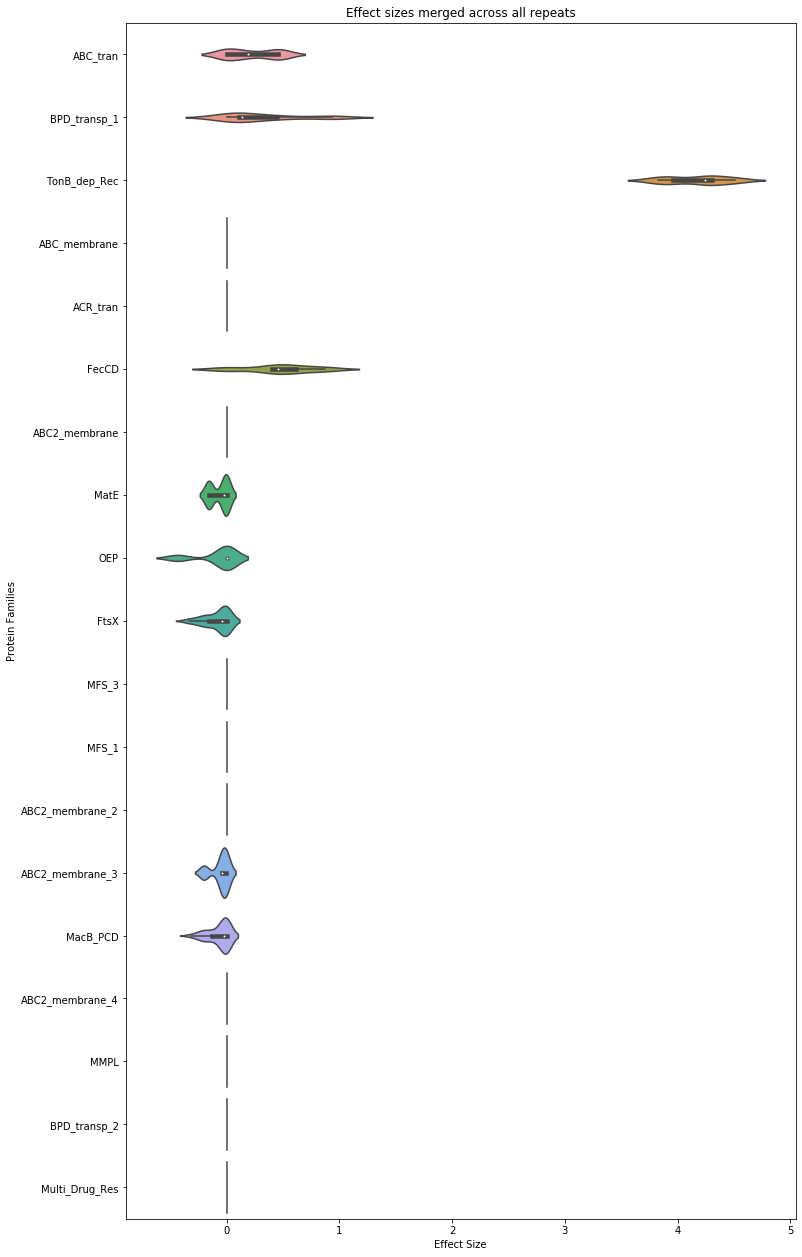

In [12]:
num_splits = 5
num_repeats = 5
C = 1.

kf = StratifiedKFold(n_splits=num_splits)
dfs = []

X, y = create_clf_data(d)
feature_names = d.columns.drop(['BGC', 'label', 'Gram'])
for i in range(num_repeats):
#     plt.figure(figsize=(12,12))
    coefs = []
    for j, (train, test) in enumerate(kf.split(X, y)):
        clf = linear_model.LogisticRegression(C=C, penalty='l1', solver='liblinear')
        X_train, y_train = create_clf_data(d.iloc[train])
        X_test, y_test = create_clf_data(d.iloc[test])

        fit_clf, _, _, _ = fit_classifier(X_train, y_train, clf)
        
        coefs.append(np.squeeze(fit_clf.coef_))

    coefs = np.array(coefs)
    results = pd.DataFrame(coefs)
    results = results.rename(columns={i: f for i, f in enumerate(feature_names)})
    results = results.melt(var_name='feature', value_name='vals')
    dfs.append(results)
    
plt.figure(figsize=(12,22))
sns.violinplot(x='vals', y='feature', data=pd.concat(dfs))
plt.ylabel('Protein Families')
plt.xlabel('Effect Size')
plt.title(f'Effect sizes merged across all repeats')
plt.show()